# Create maps of Relative Risk due to PM2.5

In [30]:
%pylab inline
import numpy  as np
import pandas as pd
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import requests

Populating the interactive namespace from numpy and matplotlib


/Users/vonw/anaconda3/envs/work/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Determine yesterday's date.

In [2]:
now   = pd.to_datetime('now') - pd.Timedelta('1D')
year  = str(now.year)
month = str(now.month).zfill(2)
day   = str(now.day).zfill(2)

#### Download yesterday's PM2.5 forecast for the PNW from AIRPACT5

In [3]:
webAddress = 'http://lar.wsu.edu/airpact/airraid/' + year + '/' + 'PM25_24hr_' + year + month + day + '.json'
airpact    = pd.read_json('[' + requests.get(webAddress).content.decode('utf-8')[:-2] + ']')    

--2019-09-05 10:19:29--  http://lar.wsu.edu/airpact/airraid/2019/PM25_24hr_20190904.json
Resolving lar.wsu.edu... 134.121.120.167
Connecting to lar.wsu.edu|134.121.120.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5808870 (5.5M) [application/json]
Saving to: ‘PM25_24hr_20190904.json’

PM25_24hr_20190904. 100%[===================>]   5.54M  --.-KB/s    in 0.1s    

2019-09-05 10:19:29 (43.5 MB/s) - ‘PM25_24hr_20190904.json’ saved [5808870/5808870]



#### Read in the latitude and longitudes of the AIRPACT forecast

In [9]:
grid = xr.open_dataset('GRIDCRO2D')
lats = np.reshape(grid.LAT.values,(258,285))
lons = np.reshape(grid.LON.values,(258,285))

#### Read in the JSON file containing the PM2.5 forecast data

In [5]:
fn      = dweb.split('/')[-1]
f       = open(fn)
fcstmap = f.read()
fcstmap = '[' + fcstmap[:-2] + ']'
airpact = pd.read_json(fcstmap)

In [6]:
r = airpact.ROW.values
c = airpact.COL.values
pm25 = airpact.RollingA24_PM25.values.reshape(max(c),max(r)).T

#### Plot the PM2.5 map for the PNW

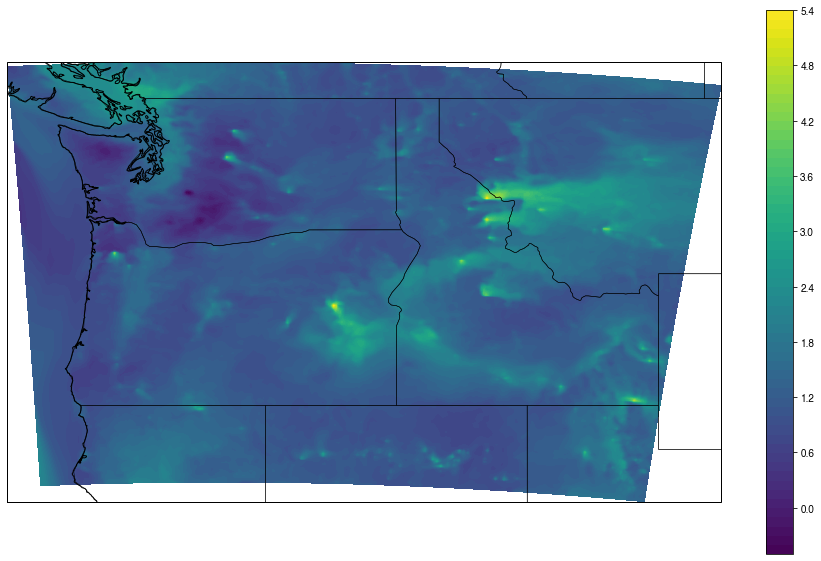

In [38]:
figure(figsize(16,10))
ax = plt.axes(projection=ccrs.PlateCarree())
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
plt.contourf(lons, lats, np.log(pm25), 60, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.colorbar()
plt.show()

#### Apply the Concentration Response Function 

In [23]:
CRFs = pd.read_csv('CRFs by age year-Table 1.csv', header=[1], na_values=['NaN', '-'])

Text(0.5, 1.0, 'Concentration Response Function for Asthma Symptoms Onset, from Matt Kadlec, WA Dept of Ecology')

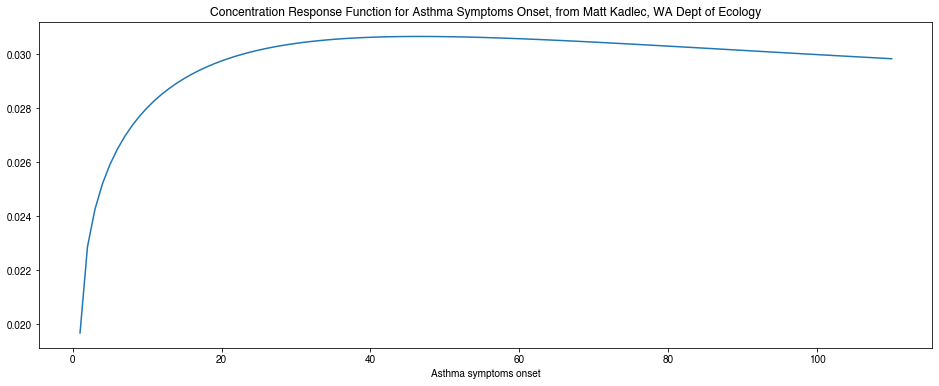

In [24]:
figure(figsize=(16,6))
plt.plot(CRFs['Age (years)'], CRFs['Asthma symptoms onset CRFs [ICD 10: J45]'])
plt.xlabel('Age (years)');
plt.xlabel('Asthma symptoms onset');
plt.title('Concentration Response Function for Asthma Symptoms Onset, from Matt Kadlec, WA Dept of Ecology')

#### Calculate a Relative Risk Map for each Age

In [25]:
RiskIncrease = np.empty((len(CRFs['Age (years)']), max(c), max(r)))
for i, crf in enumerate(CRFs['Asthma symptoms onset CRFs [ICD 10: J45]']):
    RiskIncrease[i] = 1. - np.exp(-crf * pm25)

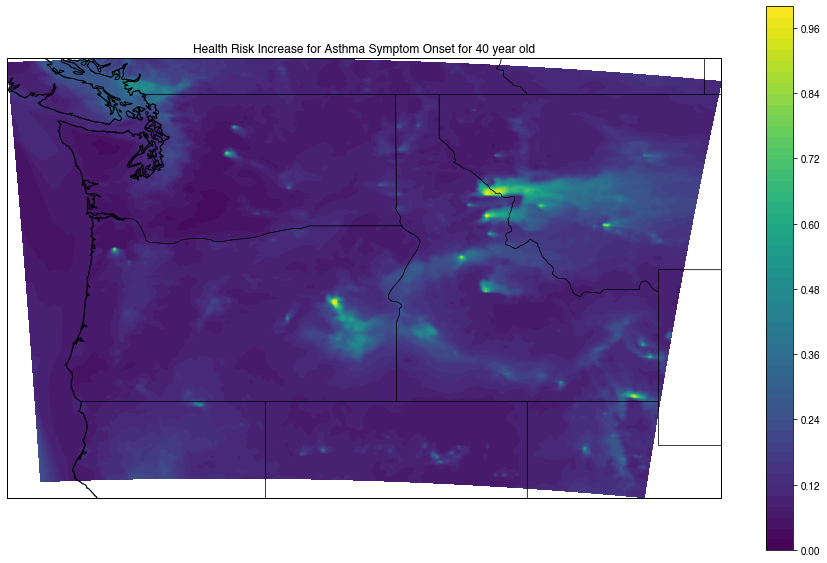

In [37]:
age = 40

figure(figsize(16,10))
ax = plt.axes(projection=ccrs.PlateCarree())
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
plt.contourf(lons, lats, RiskIncrease[age].T, 60, transform=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plt.colorbar()
plt.title('Health Risk Increase for Asthma Symptom Onset for ' + str(age) + ' year old')
plt.show()